**Initializing...**

In [ ]:
!pip install -U spacy

~~Restarting the runtime is required after the upgrade.

In [ ]:
import spacy
import numpy as np
import pandas as pd
import sys
import random
import matplotlib.pyplot as plt
!python -m spacy download en_core_web_lg


Importing the data...

In [ ]:
nlp=spacy.load('en_core_web_lg')
f=pd.read_csv('txeet.csv',dtype='string')

Ditching pandas for List.

In [ ]:
txraw=[]
for i in range(len(f)):
    txraw.append(f.loc[i].to_list())

trc=txraw.copy()                        #take a backup of the original data.

Tweets are ridden with unwanted characters.

In [ ]:
notalpha = []
for i in txraw:
    for j in i[3]:
        if j.isalpha() == False and j.isdigit() == False and j not in notalpha:
            notalpha.append(j)

notalpha.remove("'")                    # "'" and "," are needed, removing them
notalpha.remove(",")                    # from the blacklist. 
notalpha.insert(0, "&amp")              # An annoying character 
                                        # that slipped through the cracks.

Main cleaning up process.
Hashtags, handles, and urls are excluded from the process from the beginning, due to high probability of made-up names.

In [ ]:
txrawcopy = []
for i in range(len(trc)):
    x = trc[i][3]
    X = x.split()
    tmp = []
    for k in range(len(X)):
        if 'http' not in X[k] and '@' not in X[k] and '#' not in X[k]:
            for nal in notalpha:
                if nal in X[k]:
                    X[k] = X[k].replace(f'{nal}', ' ')

            X[k] = X[k].replace('wanna', 'want to')
            X[k] = X[k].replace('gonna', 'going to')
            X[k] = X[k].replace('  ', ' ')
            for j in ['corona', 'virus', 'covid']:  #Spacy does not recognize new names given to covid-19, 
                if j in X[k].lower():               #replacing all possibilities with "virus".
                    X[k] = 'virus'

            tmp.append(X[k])
            
        tmp2 = ' '.join(tmp)
    if tmp2.__len__() > 0:
        while '  ' in tmp2:
            tmp2 = tmp2.replace('  ', ' ')

    tmp2 = tmp2.strip()
    txrawcopy.append([trc[i][0], trc[i][1], trc[i][2], tmp2])


Beginning with Spacy. Finding the noun chunks of each tweet.

In [ ]:
twtchunks2 = []
for i in txrawcopy:
    cc = nlp(i[3]).noun_chunks              #feeding the tweet to nlp
    uu = []
    tm = []
    for k in cc:
        uu.append(k.lemma_)                 #breaking down the chunks
        nn = []                             #and putting them back if they
        for j in k:                         #are not PRON, CCONJ, ADV, DET, OOV.
            jp = j.pos_                     #use spacy.explain("DET") for details.
            jl = j.lemma_
            if jp != 'PRON' and jp!='CCONJ' and jp!='ADV' and jp != 'DET' and \
                    len(jl) > 2 and j.is_oov == False:
                nn.append(j.lemma_.lower())
        Y = ' '.join(nn)
        if Y.__len__() > 0:
            tm.append(Y)
    if tm.__len__() > 0:
        twtchunks2.append([i, uu, tm])      #making a new list with original tweet(i)
                                            #unfiltered chunk(uu), and clean chunks(tm).


Combining all the noun chunks in one place.

In [ ]:
voc = []
for i in twtchunks2:
    for j in i[2]:
        voc.append(j)

Finding the the usage frequency of each noun chunk. Renaming the columns. Saving the list to a file. Finding the top 20 nouns.

In [ ]:
noun_count=pd.Series(voc).value_counts().reset_index()
noun_count.rename(columns={'index':'Nouns',0:'No. of usage'},inplace=True)
noun_count.to_csv('noun count.csv', index=False)

top20=noun_count.loc[:19]['Nouns'].to_list()

Main calculations. It can take a few hours for all the 40K tweets. You can adjust the Range and Batch sizes with smaller numbers, then level up. The stdout shows the progress.

In [ ]:
"""""""""
This section calculated the similarity of all noun chunks, with the top20
list. Higher similarity (max=1) means closer relevance. Since we are dealing
with a huge number of tokens, doing them one by one takes a very long time.
Instead, we feed the entire words in batches to nlp, and then slice the tokens
and measure the similarity. There are measures in place to make sure the tokenization
process and slicing and recombining are carried out without a mistake.

"""""""""

similaritymatrix = []
Range = 1000                                        #Range should be a factor of batch. 
Batch = 100                                         #(100*10,100*300 etc.)             


twwwt=random.choices(twtchunks2,k=Range)            #choose a sample of tweets.

for K in range(0, Range, Batch):
    V = []                                          #temporary collector list.
    twm = []                                
    tw = 0
    en = 0
    tm = []
    
    for i in range(K, K + Batch):
        twm.append(twwwt[i][2].__len__())           #collecting no. of chunks in each tweet.
        for k in twwwt[i][2]:   
            V.append(k)                             #all tweets in the batch are combined
    ten = twm[tw]                                   #tweet end (ten)
    tok = nlp(' '.join(V))                          #tokens of the batch
    
    for j in range(len(V)):
        m = len(V[j].split())                       #splitting up the chunks
        bg = en                                     #beginning of a token(bg)
        en = bg + m                                 #end=bg+length
        tt = tok[bg:en]                             #sliced token
        while tt.text != V[j]:                      #strechting the en to catch up
            en += 1
            tt = tok[bg:en]
        
        
        # if tt.has_vector == False:                         #<--USE FOR DEBUG AND TEST
        # print(j, bg, tt, tt.has_vector, '#', V[j])
        
        
        if tt.has_vector and tt.__len__() > 0 and tt.text == V[j]:
            for tp in top20:
                x = nlp(tp).similarity(tt)          #saftey measure to ensure sliced token
                # print(j,tp,tt,x)                  #and splitted chunk are the same
                tm.append(x)
        if tt.has_vector == False:
            for tp in top20:
                x = -0.01                           #it is likely a noun chunk has no vector
                # print(j,K+tw,tp,tt,x)             #replacing similarity with -0.01 
                tm.append(x)
        if j + 1 == ten:
            similaritymatrix.append([twwwt[K + tw][2], np.array(tm).reshape(twm[tw], 20)])
            
            
            try:
                tw += 1
                twl = twm[tw]                       #adjusting the slicer on the tweet 
                tbg = ten                           #noun chunks.
                ten = tbg + twl
                tm = []
            except:
                pass

    if K % 10 == 0:
        sys.stdout.write(f"Processed tweets:[{K}] \r")
        sys.stdout.flush()


The relavance order idea is based on the number of noun chunks with the similarity value more than 0.7. Also the length of the tweet (no. of noun chunks) is also factored in (t4). 

You can see the most relevant tweets in higher indices of "sortedmatrix" (eg. sortedmatrix[-30:]), there are valubale information in the irrelevant tweets too.

The histogram shows what fraction (hist) of tweets have what length (hbins). 
Here, tweet length equals no. of tweet noun chunks.

In [ ]:
order = []
for i in similaritymatrix:
    t1 = np.where(i[1] > .7)[0]
    t2 = len(t1)
    t3 = i[1].shape[0]
    t4 = t2 / t3
    order.append(t4)

argsort = np.argsort(order)

length = []
sortedmatrix = np.array(similaritymatrix,dtype="object")[argsort]

for i in sortedmatrix:
    length.append(len(i[0]))

hist,hbins=np.histogram(length,bins=np.arange(0,20,1),density=True)

Plotting the histogram and relevancy order.
It shows highest relevant tweets are the shortest, and second to that, medium length tweets. Long tweets are not entirely irrelevant or relevant.

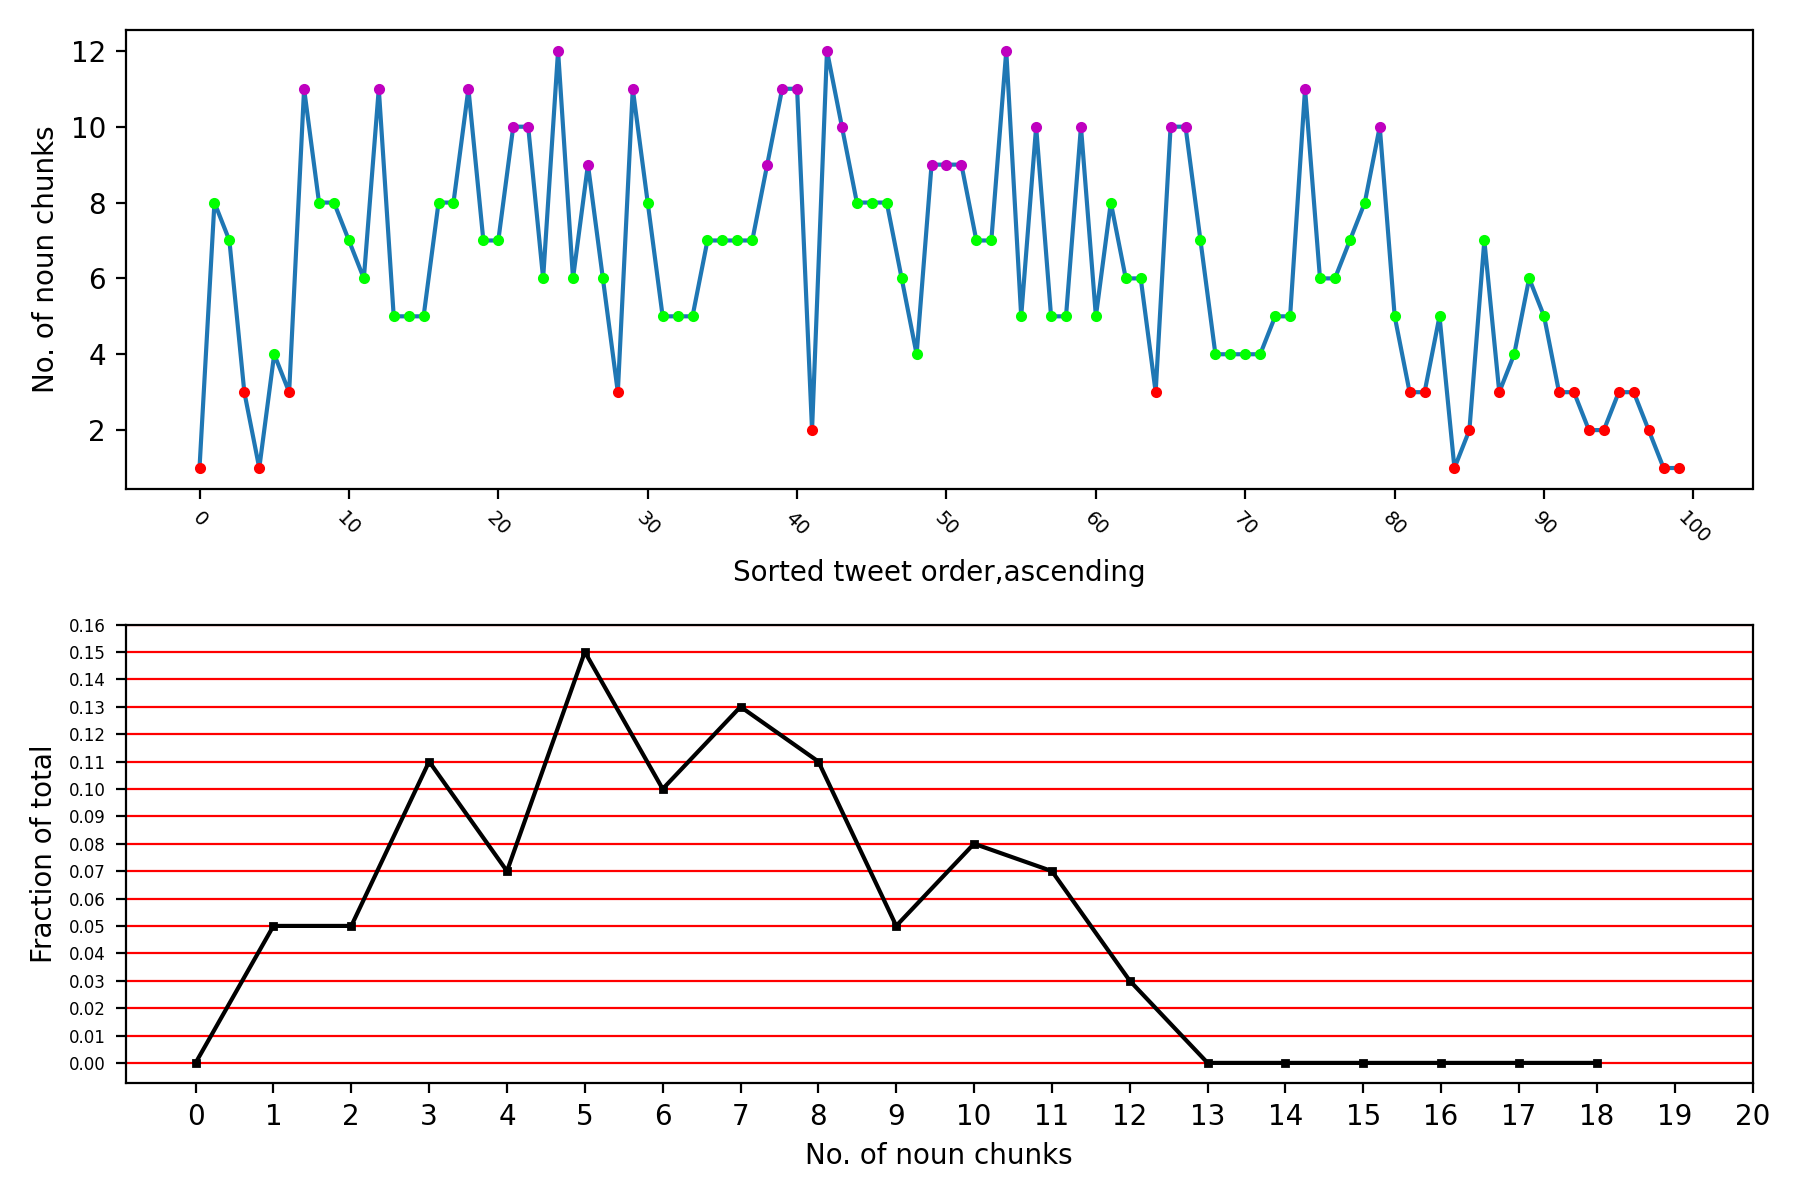

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(9, 6))

ax1.set_xticks(np.arange(0, len(length)+len(length)//10, len(length) // 10))
ax1.set_xlabel("Sorted tweet order,ascending")
ax1.set_ylabel("No. of noun chunks")
ax1.set_yticks(np.arange(0, 21, 2))
ax1.tick_params(axis='x', labelsize=7)
ax1.tick_params(axis='x', labelrotation=315)

ax2.plot(hbins[:-1], hist, c='k', marker='s', markersize=2)
ax2.set_xlabel("No. of noun chunks")
ax2.set_ylabel("Fraction of total")
ax2.set_xticks(np.arange(0, 21, 1))
ax2.set_yticks(np.arange(0, np.max(hist) + .02, .01))
ax2.yaxis.grid(c='r')
ax2.tick_params(axis='y', labelsize=6)

plt.tight_layout()

ax1.plot(length)

for i in range(len(length)):
    if length[i] in range(0,4):
        ax1.plot(i, length[i], color='r', marker='.', markersize=6)
for i in range(len(length)):
    if length[i] in range(4,9):
        ax1.plot(i, length[i], color='lime', marker='.', markersize=6)
for i in range(len(length)):
    if length[i] in range(9,20):
        ax1.plot(i, length[i], color='m', marker='.', markersize=6)



If you are interested to see what was said about a topic, you can use this function, and it won't dissapoint.

In [ ]:
def twtfinder(words):
    """Find any words in the tweet collection."""
    t=[]
    for i in twtchunks2:
        if words.lower() in i[0][3].lower():
            t.append(i[0])
    return t,len(t)


"""""""""
Example:

twtfinder("wedding dress")

([['23617', 'Westland, MI', '26-03-2020', 'Toilet Paper wedding dress'],
  
  ['28254','New Zealand','04-04-2020',
  
  'A reverend hosting an online dance rave farming mums in wedding dresses drinking wine
   and a woman shopping in an inflatable unicorn costume here are 
   some of the things Kiwis are doing to keep each other smiling during lockdown']],
 
 2)

""""""""